In [32]:
import pandas as pd
import numpy as np
import datetime as dt
# from pandas.parser import CParserError
from pandas.errors import ParserError
import os
import matplotlib.pyplot as plt
import empyrical
import chart_studio.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import HTML
os.chdir('/Users/ravpritpalkohli/Desktop/BVentures/BSE/NSE1169/Data122019/')

<br>
Import necessary modules. We will mostly be dealing with pandas and making use of numpy for faster calculations. <br>

In [2]:
import tsmom

//anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning:

Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.



<br> Import the custom module I made called tsmom. This contains the necessary functions to run the below script. It is available on https://github.com/rkohli3/TSMOM/blob/master <br><br>


In [3]:
def get_adj_price(fact_df, series):
    """The function gets the adjusted prices for splits and dividends for data of EOD prices stock. CMIE provides
    EOD unadjusted provides, however, provides adj factors mapped to a certain time date. We take the adjusted 
    factors, group them by the certain stock mapped to timeseries. Then we move backwards in series to account for
    any changes for splits and dividends. Note this is specific to CMIE data only
    
    params:
        fact_df: adjusted factor timeseries or dataframe of all stocks
        series: EOD unadjusted prices of stock
        
    returns: 
        pd.Series of daily prices adjusted for splits and dividends"""
    name = series.name
    if name in fact_df.columns:
        factors = fact_df.loc[~fact_df.loc[:, name].isnull(), name]
        rev = factors.iloc[::-1].cumprod()
        multiplier = rev.sort_index(ascending = True)
        prices = series.copy(deep = True)
        empty = []
        prices.loc[:multiplier.index[0] - dt.timedelta(1)]
        for i in range(len(factors)):
            if len(factors) == 1:
                values = prices.loc[:multiplier.index[i] - dt.timedelta(1)].values * multiplier.iat[i]
                empty.extend(values)

            elif len(factors) > 1:
                if i == 0:
                    values = prices.loc[:multiplier.index[i] - dt.timedelta(1)].values * multiplier.iat[i]
                    empty.extend(values.tolist())
                elif (i > 0):
                    values = prices.loc[multiplier.index[i-1] : multiplier.index[i] - dt.timedelta(1)].values * multiplier.iat[i]
                    empty.extend(values.tolist())


        empty.extend(prices.loc[multiplier.index[len(factors)-1]:] * 1)     
        adj_price = pd.Series(empty, index = prices.index, name=factors.name)

        return adj_price
    else:
        return series

<br><p>The function gets the prices adjusted for splits and dividends for EOD stock prices. CMIE provides EOD unadjusted prices, however, does provide adjustment factors mapped to a timestamp date for each stock adjustment.</p> <p> We take the adjusted factors, group them by the stock and map them to our price timeseries. Then we move backwards in series to account for any changes for splits and dividends. Note this is specific to CMIE data only</p><br>

### <u>Let's go over the code</u>

```python
def get_adj_price(fact_df, series):
    name = series.name
    if name in fact_df.columns:
        ## Here fact_df is the df of adjustment factors with index as timestamp and columns as tickers, 
        ## an aggregated version of the above output
        
        factors = fact_df.loc[~fact_df.loc[:, name].isnull(), name]
        rev = factors.iloc[::-1].cumprod()
        ## Take the reverse of the factors and calculate their cumpulative product as we go backwards in time. 
        
        multiplier = rev.sort_index(ascending = True)
        prices = series.copy(deep = True)
        empty = []
        prices.loc[:multiplier.index[0] - dt.timedelta(1)]
        ## apply the adjustments for different periods
        for i in range(len(factors)):
            if len(factors) == 1:
                values = prices.loc[:multiplier.index[i] - dt.timedelta(1)].values * multiplier.iat[i]
                empty.extend(values)

            elif len(factors) > 1:
                if i == 0:
                    values = prices.loc[:multiplier.index[i] - dt.timedelta(1)].values * multiplier.iat[i]
                    empty.extend(values.tolist())
                elif (i > 0):
                    values = prices.loc[multiplier.index[i-1] : multiplier.index[i] - dt.timedelta(1)].values * multiplier.iat[i]
                    empty.extend(values.tolist())


        empty.extend(prices.loc[multiplier.index[len(factors)-1]:] * 1)     
        adj_price = pd.Series(empty, index = prices.index, name=factors.name)

        return adj_price
    else:
        return series
    ```
        

In [4]:
mainframe500 = pd.read_csv('./TradeData/TradeData.txt', 
                           sep = '|', 
                           header = 0, 
                           parse_dates= [2])

ticks500 = pd.read_table('./ID/ID.txt', 
                         sep='|', 
                         header = 0)
adj_fac500 = pd.read_table('./AdjustmentFactors/AdjustmentFactors.txt', 
                           sep = '|', 
                           header = 0, 
                           parse_dates = ['radjfact_date']
                          )

mainframe500 = mainframe500.merge(ticks500.loc[:, ['company_name', 'nse_symbol']], 
                                  how = 'inner', 
                                  on = 'company_name')


mainframe501 = pd.read_csv('./TradeData/TradeData1.txt', 
                           sep = '|', 
                           header = 0, 
                           parse_dates= [2])

ticks501 = pd.read_table('./ID/ID1.txt', 
                         sep='|', 
                         header = 0)

adj_fac501 = pd.read_table('./AdjustmentFactors/AdjustmentFactors1.txt', 
                           sep = '|', 
                           header = 0, 
                           parse_dates = ['radjfact_date'], 
                           usecols= ['company_name', 'radj_exch', 'radjfact_date', 'radj_factor']
                          )


mainframe501 = mainframe501.merge(ticks501.loc[:, ['company_name', 'nse_symbol']], 
                                  how = 'inner', 
                                  on = 'company_name')




adj_fac500 = adj_fac500.merge(ticks500.loc[:, ['company_name', 'nse_symbol']], 
                              how = 'inner', 
                              on = 'company_name')
adj_fac500 = adj_fac500.loc[adj_fac500['radj_exch'] == 'NSE', 
                            ['nse_symbol', 
                             'radj_factor', 
                             'radjfact_date']
                           ]
adj_fac501 = adj_fac501.merge(ticks501.loc[:, ['company_name', 'nse_symbol']], 
                              how = 'inner', 
                              on = 'company_name')
adj_fac501 = adj_fac501.loc[adj_fac501['radj_exch'] == 'NSE', 
                            ['nse_symbol', 
                             'radj_factor', 
                             'radjfact_date']
                           ]
mainframe500 = pd.concat([mainframe500, mainframe501])
adj_fac500 = pd.concat([adj_fac500, adj_fac501])

In [5]:
mainframe500.head()
adj_fac500.head()

,co_code,company_name,co_stkdate,nse_opening_price,nse_high_price,nse_low_price,nse_closing_price,nse_returns,nse_traded_qty,nse_market_cap,nse_pe,nse_pb,nse_bv_per_share,nse_symbol,nse_no_of_trans
0,11,20 MICRONS LTD.,2008-10-06,80.0,80.0,31.60,33.65,1.00,11750865.0,475.1521,10.6061,1.1741,28.6606,20MICRONS,NaN
1,11,20 MICRONS LTD.,2008-10-07,32.0,38.0,27.85,30.10,0.89,4556711.0,425.0246,9.4872,1.0502,28.6606,20MICRONS,NaN
2,11,20 MICRONS LTD.,2008-10-08,28.0,29.2,25.10,26.50,0.88,1232192.0,374.1911,8.3525,0.9246,28.6606,20MICRONS,NaN
3,11,20 MICRONS LTD.,2008-10-10,24.9,24.9,21.65,23.20,0.88,603964.0,327.5937,7.3124,0.8095,28.6606,20MICRONS,NaN
4,11,20 MICRONS LTD.,2008-10-13,24.3,26.6,23.30,24.65,1.06,449346.0,348.0683,7.7694,0.8601,28.6606,20MICRONS,NaN


,nse_symbol,radj_factor,radjfact_date
1,20MICRONS,0.50,2013-01-28
3,3IINFOTECH,0.50,2007-08-27
7,8KMILES,0.50,2016-10-10
8,8KMILES,0.75,2016-10-10
10,AARTIDRUGS,0.50,2015-03-24


<br><p> In the first part of the code, we start by reading the date files. **Note**, these are not time series but do have data for each day and stock.  <p>In the second part, we merge the ticker names with company name for the purpose of keeping the names short and to use the NSEI ticker names. This column is called **nse_symbol**

In [6]:
main_start = dt.date(2000, 1, 1)
mark_cap500 = mainframe500.pivot(index= 'co_stkdate', 
                                 columns= 'nse_symbol', 
                                 values= 'nse_market_cap').loc[main_start:, :]

unadj_prices = mainframe500.pivot(index= 'co_stkdate', 
                                  columns= 'nse_symbol', 
                                  values= 'nse_closing_price').loc[main_start:, :]

adjfactors = adj_fac500.pivot_table(values= 'radj_factor', 
                                    index = 'radjfact_date', 
                                    columns = 'nse_symbol', 
                                    aggfunc= 'prod')
unadj_prices.tail()

nse_symbol,20MICRONS,3IINFOTECH,3MINDIA,8KMILES,AARTIDRUGS,AARTIIND,AAVAS,ABAN,ABB,ABBOTINDIA,...,YOKOGAWA,ZANDUREALT,ZEEL,ZEELEARN,ZEEMEDIA,ZENITHCOMP,ZENSARTECH,ZODIACLOTH,ZUARIGLOB,ZYDUSWELL
co_stkdate,,,,,,,,,,,,,,,,,,,,,
2020-03-25,20.00,1.30,16861.35,NaN,475.90,705.20,874.50,13.10,834.55,14232.65,...,NaN,NaN,125.50,13.60,3.00,NaN,68.60,90.25,24.90,1208.10
2020-03-26,21.75,1.35,17939.85,NaN,487.30,738.65,961.95,13.45,861.30,14392.55,...,NaN,NaN,128.75,13.65,3.15,NaN,75.35,98.00,26.75,1210.65
2020-03-27,23.15,1.35,17648.60,NaN,499.65,765.90,1058.10,13.50,852.50,14146.10,...,NaN,NaN,128.05,13.65,3.30,NaN,77.95,99.95,26.00,1243.50
2020-03-30,24.30,1.35,17436.35,27.55,487.50,728.50,1121.35,13.90,881.40,15210.45,...,NaN,NaN,125.65,12.90,3.45,NaN,83.10,98.95,26.50,1265.50
2020-03-31,25.55,1.30,18827.95,NaN,502.30,766.75,1188.85,14.00,935.40,15451.10,...,NaN,NaN,123.95,12.15,3.60,NaN,88.00,103.45,27.40,1299.35


<p>We then pivot our `mainframe500` to get unadjusted prices of each stock as time series. We do this for adjustment factors as well

In [8]:
adj_prices = unadj_prices.apply(lambda x: get_adj_price(adjfactors, x))
adj_prices = adj_prices.dropna(how = 'all', axis = 1)

# adj_prices_biased = adj_prices.loc[:, cur_500_ticks.values.tolist()]

Call the function on each column (series) of the unadjusted prices in `unadj_prices` dataframe to calculate the adjuted prices

Let's compare the unadjusted prices and adjusted prices by plotting them and figure out whether the code makes sense.

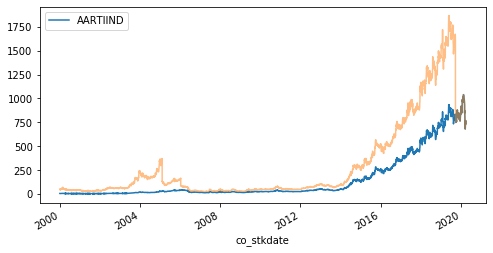

In [9]:
adj_prices.AARTIIND.plot(figsize = (8, 4), legend = True)
unadj_prices.AARTIIND.plot(alpha = 0.5)

In `Fig` above the line in blue is the adjusted pries and the line in orange is unadjusted price with spikes (twice). <br><p>We can see the somewhere around **2005** and **2006** there was an adjustment to AARTIIND's prices. Let's check what date exactly it was!!

So we were right in fact!

In [21]:
import matplotlib.pyplot as plt
import investpy.indices as idc
import investpy.bonds as bonds
india_idx = idc.get_indices(country = 'India')
tick = (india_idx.loc[india_idx['name'] == 'Nifty 500',:])

# tick
nifty500 = idc.get_index_historical_data('nifty 500', 
                                         'India', 
                                         from_date = '01/01/2000', 
                                         to_date= '31/03/2020', interval='Monthly')



nifty500 = nifty500.loc[~nifty500.index.duplicated()]
idx = [i + pd.DateOffset(months = 1) for i in nifty500.index]
nifty500.index = idx
nifty500idx = nifty500['Close']
tbill = bonds.get_bond_historical_data('India 3M', 
                                       from_date = '01/01/2000', 
                                       to_date= '31/03/2020', 
                                       interval='Monthly')

tbill = tbill.loc[~tbill.index.duplicated()]
tbill.index = pd.DatetimeIndex(tbill.index)
tbill = (tbill.reindex(nifty500.index)).dropna()
tbill_adj = tbill.Close/1200


Let's call the data for NSE500 index and get the daily and monthly returns for our analysis!! <p>For simplicity I have also provided the source code of ```get_rets``` from my custom module
    
```python
def get_rets(data, kind = 'arth', freq = 'm', shift = 1):
    """Function to get returns from a Timeseries (NDFrame or Series)

    params:
        data: `Dataframe` or `Series` daily EOD prices
        kind: (str) 'log'(default) or arth
        freq: (str) 'd' (default), 'w', 'm'

    returns:
        dataframe or Series"""
    if (isinstance(data, pd.core.series.Series)) or (isinstance(data, pd.core.frame.DataFrame)):

        if freq == 'm':
            data_prd = data.resample('BM').last().ffill()
        elif freq == 'd':
            data_prd = data
        elif freq == 'w':
            data_prd = data.resample('W-Fri').last().ffill()

        if kind == 'log':
            returns = (np.log(data_prd/data_prd.shift(shift)))
        elif kind == 'arth':
            returns = data_prd.pct_change(periods = shift)
    elif (isinstance(data, np.ndarray)):
        raise KeyError('Data is not a time series. Pass data with index as datetime object')

    return returns
```

In [11]:
daily_cum = adj_prices.apply(lambda x: tsmom.get_eq_line(x, data = 'prices', dtime= 'daily'))
mnth_cum = adj_prices.apply(lambda x: tsmom.get_eq_line(x, data = 'prices'))


<br><p>Next, get the cumulative daily returns of each stock in our adj_prices dataframe, which is timeseries of EOD prices. <br><p>We do this because our main function `tsmom` calls the monthly cumulative returns and monthly ex ante volatility as its required inputs

In [12]:
daily_vol = adj_prices.apply(lambda x: tsmom.get_exante_vol(x, 
                                                            com = 60, 
                                                            alpha = None,
                                                            dtype = 'prices',
                                                            dtime = 'daily'))
mnth_vol = daily_vol.resample('BM').last()

# daily_vol_garch = adj_prices.apply(lambda x: tsmom.get_inst_vol(x, annualize= 'd'))
# mnth_vol_garch = daily_vol_garch.resample('BM').last()

In [15]:
# tick = '20MICRONS'
# vols = (pd.concat([mnth_vol[tick], 
#             mnth_vol_garch[tick]], 
#            axis = 1, 
#            keys = ['EWM', 'GARCH']
#           ).dropna())


<br> <p> We then find the monthly ex ante volatility of each stock in our dataframe. Again for simiplicity I am posting the source code for calculatin of ex ante volatility. 

```python
def get_exante_vol(series, alpha = 0.05, com = 60, dtime = 'monthly', dtype = 'returns'):

    """F: that provides annualized ex ante volatility based on the method of Exponentially Weighted Average\n
    This method is also know as the Risk Metrics, where the instantaneous volatility is based on past volatility\n
    with some decay

    params:
    -------

        series: pandas series
        com: center of mass (optional) (int)
        dtime: str, (optional), 'monthly', 'daily', 'weekly'

    returns:
        ex-ante volatility with time index"""
    if (isinstance(series, pd.core.series.Series)) and (isinstance(series.index, pd.DatetimeIndex)):
        pass
    else:
        raise NotImplementedError('Data Type not supported, should only be timeseries')
    if dtype == 'prices':
        series = get_rets(series, kind = 'arth', freq = 'd')

    vol = series.ewm(alpha = alpha, com = com).std()
    ann_vol = vol * np.sqrt(261)

    if dtime == 'daily':
        ann_vol_prd = ann_vol

    elif dtime == 'monthly':
        ann_vol_prd = ann_vol.resample('BM').last().ffill()

    elif dtime == 'weekly':
        ann_vol_prd = ann_vol.resample('W-Fri').last().ffill()


    return ann_vol_prd
```  

In [13]:
unlevered = tsmom.get_tsmom_port(mnth_vol, mnth_cum)
levered = tsmom.get_tsmom_port(mnth_vol, mnth_cum, flag = True, scale = 0.5)

/Users/ravpritpalkohli/Desktop/BVentures/TSMOM/tsmom.py:621: RuntimeWarning:

divide by zero encountered in double_scalars



Find the levered and unlevered portfolios by calling in the function get_tsmom_port. For more on the source code, please click on the link https://github.com/rkohli3/TSMOM. I am posting the main code that calculates the monthly PnL for our strategy.
```Python

def tsmom(series, 
          mnth_vol, 
          mnth_cum, 
          tolerance = 0, 
          vol_flag = False, 
          scale = 0.4, 
          lookback = 12):

    """Function to calculate Time Series Momentum returns on a time series.
    params:
        series: used for name purpose only, provide a series with the name of the ticker
        mnth_vol: Monthly Ex Ante volatility
        tolerance: (optional) -1 < x < 1, for signal processing, x < 0 is loss thus short the asst and vice-versa
        vol_flag: (optional) Boolean default is False,
        scale: (optional) volatility scaling parameter
        lookback: (optional) int, lookback months

    returns:
        time series momentum returns"""
    
    ast = series.name
    df = pd.concat([mnth_vol[ast], 
                    mnth_cum[ast], 
                    mnth_cum[ast].pct_change(lookback)],
                      axis = 1,
                      keys = ([ast + '_vol', 
                               ast + '_cum', 
                               ast + '_lookback']))
    ## Get the relevant monthly cumulative returns, exante volatility and the past 12 month returns,
    ## excluding the most recent one (addressed in loop)
    cum_col = df[ast + '_cum']
    vol_col = df[ast + '_vol']
    lback = df[ast + '_lookback']
#    n_longs = []
#    n_shorts = []
    pnl_long = {pd.Timestamp(lback.index[lookback]): 0}
    pnl_short = {pd.Timestamp(lback.index[lookback]): 0}
    lev_dict = {pd.Timestamp(lback.index[lookback]): 1}
    ## Create dictionaries with relevant starting values.

    for k, v in enumerate(lback):
        if k <= lookback:
            continue
        if vol_flag == True:
            ## Levered by ex-ante volatility
            leverage = (scale/vol_col[k-1])
            if lback.iloc[k-1] > tolerance:
                ## Long
                pnl_long[lback.index[k]] = ((cum_col.iloc[k]/float(cum_col.iloc[k-1])) - 1) * leverage
                lev_dict[lback.index[k]] = leverage
            elif lback.iloc[k-1] < tolerance:
                ## Short
                pnl_short[lback.index[k]] = ((cum_col.iloc[k-1]/float(cum_col.iloc[k])) - 1) * leverage
                lev_dict[lback.index[k]] = leverage
        elif vol_flag == False:
            leverage = 1
            if lback.iloc[k-1] > tolerance:
                ## Long
                pnl_long[lback.index[k]] = ((cum_col.iloc[k]/float(cum_col.iloc[k-1])) - 1)
                lev_dict[lback.index[k]] = leverage
            elif lback.iloc[k-1] < tolerance:
                ## Short
                pnl_short[lback.index[k]] = ((cum_col.iloc[k-1]/float(cum_col.iloc[k])) - 1)
                lev_dict[lback.index[k]] = leverage
    new_lev = pd.Series(lev_dict)
    new_longs = pd.Series(pnl_long)
    new_shorts = pd.Series(pnl_short)
    new_longs.name = ast
    new_shorts.name = ast
    new_lev.name = ast + 'Leverage'
    return new_longs, new_shorts, new_lev
 ```


In [22]:
strat_unlevered = unlevered.TSMOM
strat_levered = levered['TSMOM VolScale']
unlevered.loc[:, 'Cumulative'] = tsmom.get_eq_line(strat_unlevered)
levered.loc[:, 'Cumulative'] = tsmom.get_eq_line(strat_levered)
nifty_m_rets = (nifty500idx.pct_change()).dropna()
nifty_m_rets = nifty_m_rets[strat_levered.index[0]:]
nifty_m_rets.index = (strat_levered.index)
nifty_m_rets.name = 'Nifty500'
nifty_m_cum = tsmom.get_eq_line(nifty_m_rets)

In [23]:
adj_m_prices = adj_prices.resample('BM').last()
adj_m_prices_index = adj_m_prices.loc[unlevered.index[0]:, :]
# adj_m_prices.dropna(axis = 1, how = 'all', inplace = True)
ew = adj_m_prices_index.pct_change().mean(axis = 1)
ew.name = 'Equally Weighted'
EW = (1 + ew.fillna(0)).cumprod()

# EW.plot(logy = True, legend = True)

Next, get monthly adjusted prices from the daily adjusted prices to find our monthly returns. We do this in order to calculate PnL for the equally weighted Long Only portfolio of our stocks for comparison.<br><br>

In [24]:
# importlib.reload(tsmom)
pd.concat([tsmom.get_perf_att(strat_unlevered, nifty_m_rets), 
           tsmom.get_perf_att(strat_levered, nifty_m_rets), 
           tsmom.get_perf_att(nifty_m_rets, nifty_m_rets), 
#            tsmom.get_perf_att(ew, nifty_m_rets)
          ], 
           axis = 1
         )

,TSMOM,TSMOM VolScale,Nifty500
Annualized_Mean,0.45606,0.47930,0.13591
Annualized_Volatility,0.15475,0.15639,0.24897
Sharpe Ratio,2.947,3.065,0.546
Calmar Ratio,2.22,3.424,0.18
Alpha,0.042,0.043,-0
Beta,-0.311,-0.268,1
T Value (Alpha),16.091,15.767,-23.685
T Value (Beta),-8.758,-7.139,4.95666e+17
Max Drawdown,24.67%,17.01%,60.91%
Sortino Ratio,7.532,9.95,0.623


In [25]:
# 
# rf_ind = pd.read_excel('T-Bill1995.xlsx', skiprows= 5, parse_dates= [0], index_col= [0]).sort_index(ascending = True)
# rf_ind = rf_ind.resample('BM').last()/1200
# rf_ind = (rf_ind.reindex(strat_levered.index)).fillna(0)
# rf_ind = rf_ind.PX_LAST
rf_ind = tbill_adj
# (pd.concat([(strat_unlevered - rf_ind), 
#             (strat_levered - rf_ind), 
#             (nifty_m_rets - rf_ind)], 
#            axis = 1, 
#            keys = ['TSMOM Excess', 
#                    'TSMOM VolScale Excess', 
#                    'Market Excess']
#           )).to_csv('alpha.csv')

Text(0.5, 1.0, 'Monthly Returns Scatter Plot')

Text(0.5, 0, 'Nifty500 Returns %')

Text(0, 0.5, 'TSMOM VolScale Returns %')

(-10, 30)

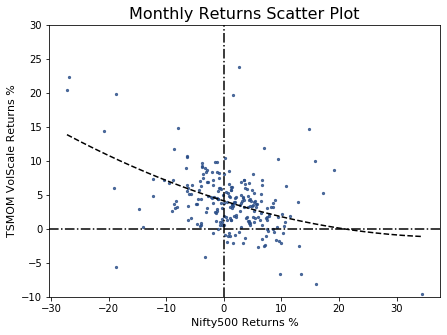

In [26]:
from scipy.interpolate import UnivariateSpline
ax, fig = plt.subplots(figsize = (7, 5))
plt.scatter(nifty_m_rets.fillna(0) * 100, 
            strat_levered * 100, 
            c = '#284c87', 
            marker= 'o', 
            s = 5,
            alpha = 0.8)
model = np.polyfit(x = nifty_m_rets.fillna(0) * 100, 
                   y = strat_levered * 100, 
                   deg = 2)
f = np.poly1d(model)

xs = np.linspace(np.min(nifty_m_rets.fillna(0)) * 100, 
                 np.max(nifty_m_rets.fillna(0)) * 100, 
                 250)
ys = f(xs)
plt.plot(xs, ys, ls = '--', c = 'black')

plt.axhline(y = 0, c = 'k', ls = '-.')
plt.axvline(x = 0, c = 'k', ls = '-.')
plt.title('Monthly Returns Scatter Plot', 
          dict(fontsize = 16))
plt.xlabel('Nifty500 Returns %', 
          dict(fontsize = 11, 
                color = 'k'))
plt.ylabel('TSMOM VolScale Returns %', 
           dict(fontsize = 11, 
                color = 'k'))
plt.ylim(-10, 30)

In [28]:
# df = pd.concat([strat_unlevered, nifty_m_rets], axis = 1, keys = ['TSMOM', 'Nifty500'])
# import seaborn as sns
# fig, ax = plt.subplots(figsize = (12, 7))
# sns.boxplot(df.TSMOM.index.year, df.TSMOM, ax = ax )
main_dir = '/Users/ravpritpalkohli/Desktop/BVentures/TSMOM/Plots/Unbiased/'

Get the results!! 

## Plot the essentials!

- Drawdowns
- Monthly Returns Heatmap
- Cumulative Returns
- Annual Returns

In [15]:
# from importlib import reload
# reload(tsmom)
tsmom.underwater(strat_unlevered, nifty_m_rets,
                 width = 550, 
                 height = 300, 
                 online= False, 
                 range = [-65, 0],
                 plt_type= 'plot', 

                 filename= main_dir + 'IndUnderwareUnlever.html'
                )
tsmom.underwater(strat_levered, nifty_m_rets,
                 width = 550, 
                 height = 300, 
                 range = [-65, 0],
                 online= False, 
                 plt_type= 'plot', 
                 filename= main_dir + 'IndUnderwareVol.html'
                )
# tsmom.underwater(nifty_m_rets, 
#                  width = 550, 
#                  height = 250, 
#                  online= False, 
#                  plt_type= 'plot', 
#                  filename= 'UnderwaterNSE500.html')
# tsmom.underwater(ew, plt_type= 'plot', filename= 'UnderwaterEW.html')

NameError: name 'nifty_m_rets' is not defined

In [16]:

tsmom.get_monthly_heatmap(strat_unlevered,
                          online = False,
                          cmap= 'RdYlGn', 
                          filename = main_dir + 'IndMomHeatmap.html', 
                          plt_type= 'plot',
                          vmin = -30, 
                          vmax = 220,
                          height = 500,
#                           width = 550,
                          colors= ['black', 'gray', 'white']
                         )
tsmom.get_monthly_heatmap(strat_levered, 
                          cmap = 'RdYlGn',
                          online = False,
                          filename = main_dir + 'IndMomVolScaleHeatmap.html', 
                          plt_type= 'plot', 
                          vmin = -50, 
                          vmax = 220, 
                          height = 500,
#                           width = 550,
                          colors= ['black', 'gray', 'white']
                          )
# tsmom.get_monthly_heatmap(nifty_m_rets, 
#                           cmap = 'RdYlGn',
#                           online = False,
#                           filename = 'NSE500Heatmap.html', 
# #                           width = 550,
#                           plt_type= 'iplot')

NameError: name 'main_dir' is not defined

In [17]:
round(levered.Leverage.max(),2)

1.46

In [29]:
ts_idx = levered.index
init_cap = 100000
trace_10 = Scatter(x = ts_idx,
                   y = unlevered.Cumulative * init_cap,
                   visible = True, 
                   name = 'Unlevered TSMOM',
                   yaxis = 'y2',
                   line = dict(dash = 'solid',
                               color = 'black', 
                               width = 3)
                 )
trace_20 = Scatter(x = ts_idx,
                   y = unlevered.Leverage,
                   visible = True,
                   name = 'Leverage',
#                    secondary_y = False,
                   yaxis = 'y1',
                   line = dict(dash = 'dot',
                               color = '#aaa9a9', 
                               width = 1.5, 
                               )
                 )
                  
trace_30 =  Scatter(x = ts_idx,
                    y = nifty_m_cum * init_cap,
                    visible = True,
                    name = 'Nifty500',
#                     secondary_y = True,
                    yaxis = 'y2',
                    line = dict(dash = 'solid', 
                                color = 'blue', 
                                width = 3)    
                   )

trace_11 = Scatter(x = ts_idx,
                   y = (levered.Cumulative * init_cap),
                   visible = False,
                   name = 'Levered TSMOM',
#                    secondary_y = True,
                   yaxis = 'y2',
                   line = dict(dash = 'solid',
                               color = 'black', 
                               width = 3)
                 )
trace_12 = Scatter(x = ts_idx,
                   y = (levered.Leverage),
                   visible = False,
                   name = 'Leverage',
#                    secondary_y = False,
                   yaxis = 'y1',
                   line = dict(dash = 'dot',
                               color = '#aaa9a9', 
                               width = 1.5),
                 )
trace_13 = Scatter(x = ts_idx,
                   y = (nifty_m_cum) * init_cap,
                   visible = False,
                   name = 'Nifty 500',
#                    secondary_y = True,
                   yaxis = 'y2',
                   line = dict(dash = 'solid',
                               color = 'blue', 
                               width = 3,
                              )
                  )

trace100 = Scatter(x = EW.index ,
                   y = EW * init_cap, 
                   visible = True, 
                   name = 'EW Long Only',
#                    secondary_y = True, 
                   yaxis = 'y2', 
                   line = dict(dash = 'dashdot', 
                               color = '#51c5e9', 
                               width = 3), 
                  )
data_ttl = [trace_10, trace_20, trace_30, trace_11, trace_12, trace_13, trace100]
updatemenus = list([dict(#type="buttons", 
                         active= 0, 
                         
                         buttons=list([dict(label = 'Unlevered',  
                                            method = 'update', 
                                            args = [{'visible': [True, True, True, False, False, False, True]},]),
                       
                                       dict(label = 'Levered', 
                                            method = 'update', 
                                            args = [{'visible': [False, False, False, True, True, True, True]},]), 
                                       
                                      ]),  
                         x = 0.15,
                         y = 1
                        ),
                   ], 
                   
                  )

lay = Layout(title = dict(text = 'TSMOM scaled for volatility',
                          x = 0.5,
                          y = 0.9,
                         ),
             legend = dict(x = 0.05, y = 0.9),

             xaxis = dict(title = 'Dates', 
                          showgrid = True, 
                          showticklabels = True,
                          linecolor = 'black',
                          tickformat = '%b %Y',
                          hoverformat = '%b %Y'
                         ),
              yaxis = dict(title = 'Leverage', 
                          showgrid = False,
                          showticklabels = True,
                          linecolor = 'black',
#                            secondary_y = False,
                          range = [0.75, round(levered.Leverage.max(), 1)],   
                          ),
              yaxis2 = dict(title = 'Cumulative Returns', 
                            showgrid = False,
                            showticklabels = True,
                            linecolor = 'black',
#                             range = [4.7, 9],
#                             nticks = 5,
                            type = 'log',
#                             secondary_y = True
#                             tickformat = "$0,.0f",
                            separatethousands = True,
                            side = 'right',
                            overlaying = 'y'
                          ),
             hovermode= 'x unified',
             
             paper_bgcolor = 'white',
             plot_bgcolor = 'white',
             autosize = False,
             height = 600,
             width = 950,
             showlegend = True,
             updatemenus = updatemenus,

             shapes = [
                 {
                     'type' : 'line',
                     'xref' : 'paper',
                     'x0' : 0,
                     'y0' : init_cap,
                     'x1' : 1,
                     'y1' : init_cap,
                     'line' : {
                         
                         'color': 'black',
                         'width': 1,
                         'dash': 'dash'
                             },
                 },
                     {
                      'x0':'2000-03-15', 
                      'x1':'2000-09-15', 
                      'yref': 'paper',
                      'y0':0,
                      'y1':1,
                      'fillcolor':'rgba(30,30,30,0.3)',  
                      'opacity':.2, 
                      'line' : {'width': 0
                               },
                      },
                     {
                      
                      'x0':'2007-08-01', 
                      'x1':'2009-09-01', 
                      'yref': 'paper',
                      'y0':0,
                      'y1':1,
                      'fillcolor':'rgba(30,30,30,0.3)',  
                      'opacity':.2, 
                      'line' : {'width': 0
                               },
                      },
             ]
            )
annot = []

annot.extend([dict(xref = 'paper',
                  yref = 'paper',
                  x= 0.55, 
                  y= 0.98,
                  xanchor ='right', 
                  yanchor='auto',
                  text= 'Global Financial Crisis',
                  font=dict(family='<b>Arial<b>',
                            size= 12, 
                            color= 'black',
                           ),
                  showarrow=False), 
#             dict(xref = 'paper',
#                   yref = 'paper',
#                   x= 0.215, 
#                   y= 0.98,
#                   xanchor ='right', 
#                   yanchor='auto',
#                   text= 'Dotcom',
#                   font=dict(family='<b>Arial<b>',
#                             size= 12, 
#                             color= 'black',
#                            ),
#                   showarrow=False)
             ]
            )

lay['annotations'] = annot
fig_ttl = Figure(data = data_ttl, layout = lay)
# iplot(fig_ttl, 
#       show_link = False, 
# #       filename = '/Users/Ravi/Desktop/Git/india-famafrench/docs/_static/IndiaMom.html'
#      )
# py.iplot(fig_ttl)
plot(fig_ttl, filename= main_dir + 'CumRets.html')

'/Users/ravpritpalkohli/Desktop/BVentures/TSMOM/Plots/Unbiased/CumRets.html'

In [30]:
plot(tsmom.get_ann_ret_plot(strat_unlevered, 
                                height = 500, 
                                width = 500, 
                                x2range = [-10,100]), 
         show_link = False, 
         filename= main_dir + 'UnleveredAnnRet.html'
     )
plot(tsmom.get_ann_ret_plot(strat_levered, 
                                height = 500, 
                                width = 500, 
                                x2range = [-10,220]), 
         show_link= False, 
         filename= main_dir + 'IndVolAnnRet.html'
     )
plot(tsmom.get_ann_ret_plot(nifty_m_rets, 
                                height = 500, 
                                width = 500, 
                                x2range = [-65, 100]), 
         show_link = False, 
         filename= main_dir + 'Nifty500AnnRet.html')


//anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



'/Users/ravpritpalkohli/Desktop/BVentures/TSMOM/Plots/Unbiased/UnleveredAnnRet.html'

'/Users/ravpritpalkohli/Desktop/BVentures/TSMOM/Plots/Unbiased/IndVolAnnRet.html'

'/Users/ravpritpalkohli/Desktop/BVentures/TSMOM/Plots/Unbiased/Nifty500AnnRet.html'

In [31]:
ann_ret_comparison = pd.concat([tsmom.get_ann_ret(nifty_m_rets), 
                                tsmom.get_ann_ret(strat_unlevered)], 
                               axis = 1)
# ann_ret_comparison = pd.concat([nifty_m_rets, strat_unlevered], axis = 1)
ann_ret_comparison['Strategy Beating Market'] = np.where(ann_ret_comparison.iloc[:, 0] > ann_ret_comparison.iloc[:, 1], -1, 1)
years_not = ann_ret_comparison.loc[ann_ret_comparison.iloc[:, 2] == -1]
diff = ann_ret_comparison.iloc[:, 1] - ann_ret_comparison.iloc[:, 0]
beat_pct = diff[diff > 0].mean() 
loss_pct = diff[diff < 0].mean()
pct_wins = 1 - (len(years_not)/len(ann_ret_comparison))
print('The strategy {} beats the market {:,.2%} of the times on annual basis\
 with the average\ndifference on returns of {:,.2%}'.format(ann_ret_comparison.iloc[:, 1].name, 
                                                            pct_wins, 
                                                            beat_pct))


The strategy TSMOM beats the market 95.00% of the times on annual basis with the average
difference on returns of 43.23%


In [27]:
# def css():
#     style = open('/Users/ravpritpalkohli/Desktop/BVentures/TSMOM/custom.css', 'r').read()
#     return HTML(style)
# css()

In [94]:
long_shorts = mnth_cum.apply(lambda x: tsmom.tsmom(x, mnth_vol, mnth_cum))


In [95]:
long_side = pd.concat([i[0] for i in long_shorts], axis = 1)
# short_side = pd.concat([i[1] for i in long_shorts], axis = 1)
# port = longs.mean(axis = 1) + shorts.mean(axis = 1)
unlevered_long = long_side.mean(axis = 1)
# unlevered_long['Cumulative'] = (1 + unlevered_long).cumprod()
unlevered_long = pd.concat([unlevered_long, (1 + unlevered_long).cumprod()], 
                           axis = 1, 
                           keys= ['Unlevered', 'Cumulative'])

In [118]:
lspositions = tsmom.get_long_short(mnth_cum)
posit_n_eq = pd.concat([lspositions, unlevered_long.Cumulative * 50000], axis = 1)
dollar_val = lspositions.apply(lambda x: np.round(posit_n_eq.Cumulative.div(x), 2))

In [124]:
long_name = {}
short_name = {}
lback_ret = mnth_cum.pct_change(12).dropna(how = 'all')
for idx, row in lback_ret.iterrows():
    long_rows = row[row > 0]
    short_rows = row[row < 0]
    long_name[idx] = long_rows.index.values
    short_name[idx]= short_rows.index.values


In [98]:
shares_df = pd.DataFrame(columns=adj_prices.columns)
for (idx_l, val_l), (idx_s, val_s) in zip(long_name.items(), short_name.items()):
    l_prices = adj_m_prices.loc[idx_l, val_l]
    s_prices = adj_m_prices.loc[idx_s, val_s]
    nl_shares = np.round(dollar_val.loc[idx_l, 'Long Positions']/(l_prices))
    ns_shares = (np.round(-1 * (dollar_val.loc[idx_s, 'Short Positions']/(s_prices))))
    total_shares = pd.concat([nl_shares, ns_shares], axis = 0)
    shares_df.loc[idx_l, :] = total_shares

In [99]:
long_df = pd.DataFrame(dict([(k, pd.Series(v)) for (k,v) in long_name.items()]))

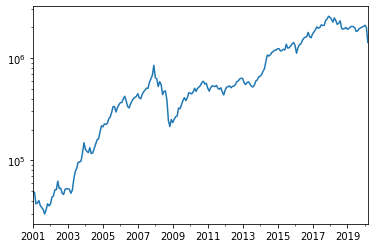

In [100]:
long_shares = shares_df[shares_df > 0]
dollar_m_positions = (long_shares.mul(adj_m_prices)).dropna(how = 'all')
dollar_m_positions.sum(axis = 1).plot(logy = True)

In [107]:
delta_shares = long_shares.diff()
writer = pd.ExcelWriter('LongIndiaMomentum.xlsx', engine = 'xlsxwriter', datetime_format = 'mmm yy')
long_shares.to_excel(writer, sheet_name= 'Number Shares')
delta_shares.to_excel(writer, sheet_name= 'Delta Shares')
pd.concat([unlevered_long.Cumulative * init_cap, nifty_m_cum * init_cap], axis = 1).to_excel(writer, sheet_name = 'Cumulative Returns')
long_df.to_excel(writer, sheet_name= 'Stocks Long')
# short_df.to_excel(writer, sheet_name= 'Stocks Short')
lspositions.to_excel(writer, sheet_name= 'Position count')
writer.close()

In [36]:
#### Research ######

# rets = adj_prices.pct_change()
# m3 = adj_prices['3MINDIA'].dropna()

# # com = 60
# span = 121
# alpha = 2/(1+span)
# ema = {}
# for i, j in enumerate(m3):
#     if i < 1:
#         ema[i] = m3.iloc[i]
    
#     else:
        
#         exp = (alpha)*m3.iloc[i] + (1-alpha)*ema[i-1]
# #         print(exp)
#         ema[i] = exp
    
# pdema = m3.ewm(alpha = alpha, adjust = False).mean()

In [37]:
# our_ema = pd.Series(ema)
# our_ema.index = m3.index
# pd.concat([our_ema, pdema, m3], axis = 1).tail(100).plot()
# os.curdir
# m3.to_csv('3MINDIA.csv')
